# Lecture 3: Oceanic lithosphere

This notebook uses the data in the `data` folder and model outputs to make figures for the lecture. 

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import xarray as xr
import pandas as pd
import cmocean
import cartopy.crs as ccrs
import verde as vd

## Global heat flow

Plot the global heat flow grid from [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389).

In [2]:
global_heat = pd.read_csv("../../data/HFgrid14.csv", sep=";")
global_heat

,longiyude,latitude,HF_pred,sHF_pred,Hf_obs
0,-179.75,89.75,121.0,19.9,NaN
1,-179.25,89.75,80.2,32.8,NaN
2,-178.75,89.75,81.1,44.5,NaN
3,-178.25,89.75,81.0,44.6,NaN
4,-177.75,89.75,109.1,19.0,NaN
...,...,...,...,...,...
259195,177.75,-89.75,75.4,36.5,NaN
259196,178.25,-89.75,75.4,36.5,NaN
259197,178.75,-89.75,75.4,36.5,NaN
259198,179.25,-89.75,75.2,36.8,NaN


Make a grid by linear interpolation so we can easily plot it.

In [3]:
interpolator = vd.ScipyGridder("linear").fit((global_heat.longiyude, global_heat.latitude), global_heat.HF_pred)
grid = interpolator.grid(region=(-180, 180, -90, 90), spacing=0.5, dims=("latitude", "longitude"), data_names=["heat_flow"])
grid.heat_flow.attrs["long_name"] = "Heat flow"
grid.heat_flow.attrs["units"] = "mW/m²"
grid

<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 721)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
  * latitude   (latitude) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
Data variables:
    heat_flow  (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder(extra_args=None, method='linear')

And finally make a map of the grid. Crop the colorbar to the same range as the paper.

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


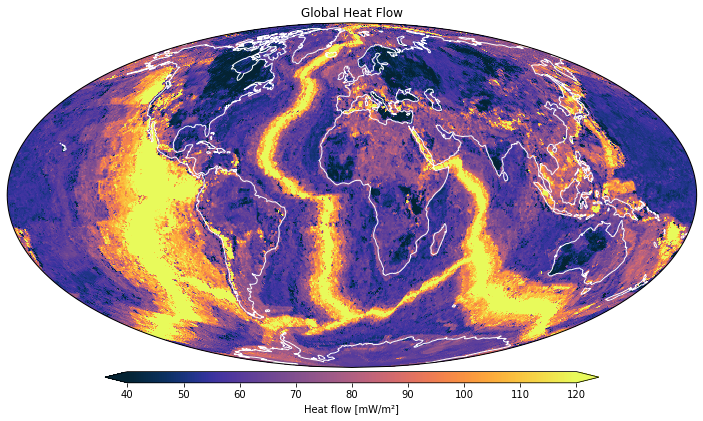

In [4]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
grid.heat_flow.plot(
    ax=ax, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.thermal, 
    vmin=40, 
    vmax=120,
    cbar_kwargs=dict(orientation="horizontal", aspect=40, pad=0.01, shrink=0.7),
)
ax.set_title("Global Heat Flow")
ax.coastlines(color="w")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("global-heat-flow.png", dpi=200)
plt.show()

## Half space model

Implement and plot the half space cooling model.

In [5]:
def halfspace(age, depth, surface_temperature, asthenosphere_temperature, diffusivity):
    """
    Half space cooling model.
    
    Calculates the model temperature given depth and age.
    Temperature units don't matter as long as they are consistent 
    (e.g., inputs in K will output in K).
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    depth
        Depth of calculation in km.
    surface_temperature
        Temperature of the surface boundary condition. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition.
    diffusivity
        Thermal diffusivity in mm²/s.
    
    Returns
    -------
    temperature
        Model temperature in the same unit as the inputs.
    """
    temperature = (
        surface_temperature 
        + (asthenosphere_temperature - surface_temperature)*sp.special.erf(
            # Convert km to mm and Ma to seconds
            depth * 1e6 / (2*np.sqrt(diffusivity * age * 31557600000000.))
        )
    )
    return temperature

Calculate the model temperatures for a range of ages and depths.

In [6]:
age, depth = vd.grid_coordinates((1, 150, 0, 150), shape=(100, 100))
temperatures = halfspace(age, depth, surface_temperature=273, asthenosphere_temperature=1300, diffusivity=1)

Plot the model temperatures.

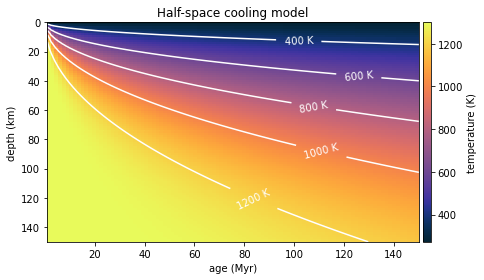

In [7]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
tmp = ax.pcolormesh(
    age, depth, temperatures,
    cmap=cmocean.cm.thermal,
)
plt.colorbar(tmp, ax=ax, aspect=30, pad=0.01, label="temperature (K)")
cs = ax.contour(age, depth, temperatures, levels=np.arange(400, 1201, 200), colors="w")
ax.clabel(cs, inline=1, fontsize=10, fmt="%.0f K")
ax.set_title("Half-space cooling model")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("depth (km)")
ax.set_ylim(depth.max(), depth.min())
plt.tight_layout()
plt.savefig("halfspace-temperature.png", dpi=200)
plt.show()

## Lithospheric thickness data

Plot the lithospheric thickness versus age data from [Leeds et al. (1974)](https://doi.org/10.1126/science.186.4159.141). The thickness was estimated from Rayleigh wave dispersion data.

In [8]:
thickness_data = pd.read_csv("../../data/leeds_etal_1974_pacific_lithosphere_thickness.csv")
thickness_data

,age_myr,thickness_km
0,150,141.1
1,120,109.1
2,100,87.1
3,70,74.1
4,50,66.1
5,30,57.1
6,15,29.1
7,5,9.1


Make a plot of the dataset.

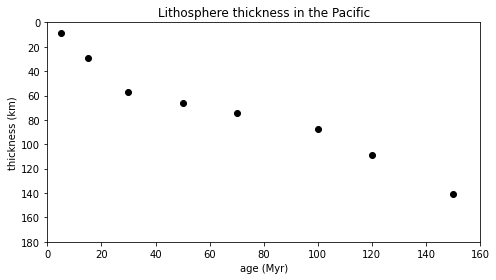

In [9]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(thickness_data.age_myr, thickness_data.thickness_km, "ok")
ax.set_title("Lithosphere thickness in the Pacific")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("thickness (km)")
ax.set_ylim(180, 0)
ax.set_xlim(0, 160)
plt.tight_layout()
plt.savefig("lithospheric-thickness-data.png", dpi=200)
plt.show()

## Comparison of HSM to real data

Now we can plot the HSM predictions to the observations.

First we need to calculate the predicted thickness from the model.

In [10]:
def halfspace_thicnkness(age, diffusivity, ratio):
    """
    Calculate the thickness of the lithosphere.
    
    Based on the given temperature ratio and diffusivity.
    """
    # convert the age to seconds and the thickness to km (from mm)
    thickness = 1e-6 *sp.special.erfinv(ratio) * 2 * np.sqrt(diffusivity * age * 31557600000000)
    return thickness

Now we can re-calculate the isotherms on the same range as our data.

In [11]:
age, depth = vd.grid_coordinates((1, 160, 0, 180), shape=(100, 100))
temperatures = halfspace(age, depth, surface_temperature=273, asthenosphere_temperature=1300, diffusivity=1)

And plot everything in one graph: data, isotherms, and predicted thickness.

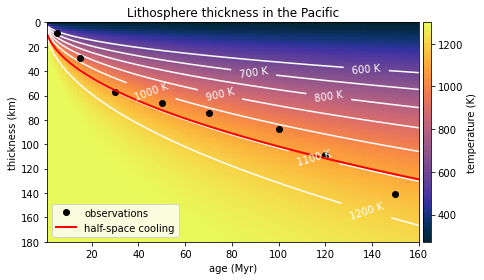

In [12]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
tmp = ax.pcolormesh(
    age, depth, temperatures,
    cmap=cmocean.cm.thermal,
)
plt.colorbar(tmp, ax=ax, aspect=30, pad=0.01, label="temperature (K)")
cs = ax.contour(age, depth, temperatures, levels=np.arange(600, 1201, 100), colors="w")
ax.clabel(cs, inline=1, fontsize=10, fmt="%.0f K")
ax.plot(thickness_data.age_myr, thickness_data.thickness_km, "o", color="k", label="observations")
ax.plot(
    age[0,:], 
    halfspace_thicnkness(age[0,:], diffusivity=1, ratio=0.8), 
    "-", 
    color="r", 
    linewidth=2,
    label="half-space cooling",    
)
ax.legend(loc="lower left")
ax.set_title("Lithosphere thickness in the Pacific")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("thickness (km)")
ax.set_ylim(180, 0)
ax.set_xlim(1, 160)
plt.tight_layout()
plt.savefig("lithospheric-thickness-halfspace-isotherms.png", dpi=200)
plt.show()

## Heat flow

Load the compiled dataset of heat flow in the oceanic lithosphere from [Davis et al. (1984)](https://doi.org/10.1111/j.1365-246X.1984.tb01962.x), [Sclater et al. (1976)](https://doi.org/10.1029/JB081i017p02997), and [Lister et al. (1990)](https://doi.org/10.1111/j.1365-246X.1990.tb04586.x). The "error" column is the 90% confidence interval in mW/m². Ages are in million years.

In [13]:
heat_flow = pd.read_csv("../../data/lithosphere_heat_flow.csv")
heat_flow["age_mean"] = 0.5*(heat_flow.age_min + heat_flow.age_max)
heat_flow["age_error"] = 0.5*(heat_flow.age_max - heat_flow.age_min)
heat_flow

,age_min,age_max,heat_flow,error,age_mean,age_error
0,168.0,172,46.8,0.5,170.00,2.00
1,175.0,195,49.4,0.2,185.00,10.00
2,163.0,167,44.2,0.9,165.00,2.00
3,142.0,150,49.5,1.1,146.00,4.00
4,120.0,140,47.0,2.0,130.00,10.00
5,90.0,100,65.3,3.4,95.00,5.00
6,80.0,90,56.6,4.1,85.00,5.00
7,15.0,20,99.8,15.0,17.50,2.50
8,5.0,10,175.1,14.4,7.50,2.50
9,5.0,10,165.1,14.4,7.50,2.50


Plot using error bars for both dimensions.

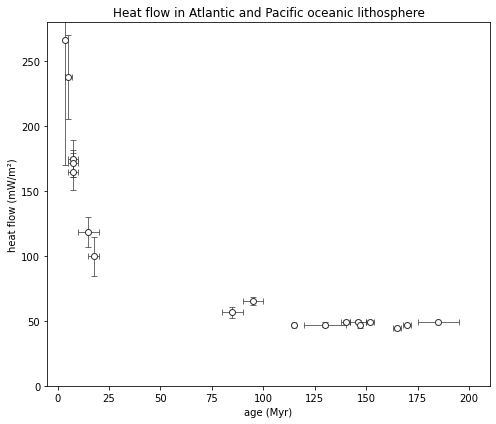

In [14]:
plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.errorbar(
    heat_flow.age_mean, heat_flow.heat_flow,
    xerr=heat_flow.age_error,
    yerr=heat_flow.error,
    fmt="o", 
    markerfacecolor="w",
    color="#333333",
    capsize=3,
    capthick=0.7,
    elinewidth=0.7,
)
ax.set_title("Heat flow in Atlantic and Pacific oceanic lithosphere")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("heat flow (mW/m²)")
ax.set_ylim(0, 280)
ax.set_xlim(-5, 210)
plt.tight_layout()
plt.savefig("lithospheric-heat-flow.png", dpi=200)
plt.show()

## Heat flow from the half-space model

We can predict the heat flow at the surface form the half-space model by taking the derivative with respect to depth and evaluating it at the surface.

In [15]:
def halfspace_heat(age, surface_temperature, asthenosphere_temperature, diffusivity, conductivity):
    """
    Heat flow from the half space cooling model.
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    surface_temperature
        Temperature of the surface boundary condition in K. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition in K.
    diffusivity
        Thermal diffusivity in mm²/s.
    conductivity
        Thermal conductivity in W/mK.
    
    Returns
    -------
    heat_flow
        Model heat flow at the surface in mW/m².
    """
    # 1000 converts from W to mW (miliWatts)
    # 1e-6 converts from mm² to m²
    # 31557600000000 converts from Myr to seconds
    flow = 1000 * conductivity * (asthenosphere_temperature - surface_temperature) / (
        np.sqrt(np.pi * 1e-6 * diffusivity * age * 31557600000000)
    )
    return flow

Now we can predict some values and compare them to the observations. Parameters were taken from Geodynamics section 4.16.

In [16]:
ages = np.linspace(1, 210, 100)
flow = halfspace_heat(ages, surface_temperature=273, asthenosphere_temperature=1573, diffusivity=1, conductivity=3.3)

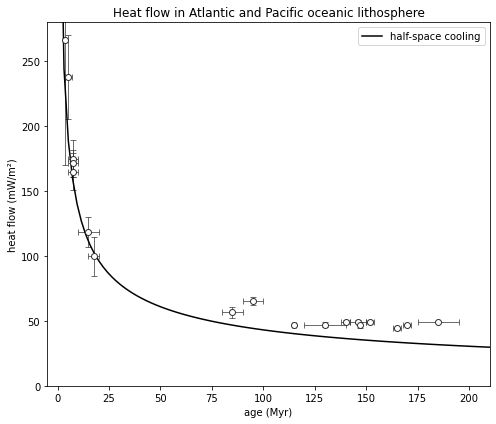

In [17]:
plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.errorbar(
    heat_flow.age_mean, heat_flow.heat_flow,
    xerr=heat_flow.age_error,
    yerr=heat_flow.error,
    fmt="o", 
    markerfacecolor="w",
    color="#333333",
    capsize=3,
    capthick=0.7,
    elinewidth=0.7,
)
ax.plot(ages, flow, "-k", label="half-space cooling")
ax.legend()
ax.set_title("Heat flow in Atlantic and Pacific oceanic lithosphere")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("heat flow (mW/m²)")
ax.set_ylim(0, 280)
ax.set_xlim(-5, 210)
plt.tight_layout()
plt.savefig("lithospheric-heat-flow-halfspace.png", dpi=200)
plt.show()

## Plate model

Implement and plot the plate cooling model.

In [18]:
def plate(age, depth, thickness, surface_temperature, asthenosphere_temperature, diffusivity, degree=100):
    """
    Half space cooling model.
    
    Calculates the model temperature given depth and age.
    Temperature units don't matter as long as they are consistent 
    (e.g., inputs in K will output in K).
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    depth
        Depth of calculation in km.
    thickness
        The thickness of the plate in km
    surface_temperature
        Temperature of the surface boundary condition. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition.
    diffusivity
        Thermal diffusivity in mm²/s.
    degree
        The maximum number of elements of the infinite series.
    
    Returns
    -------
    temperature
        Model temperature in the same unit as the inputs.
    """
    temperature = (
        surface_temperature 
        + (asthenosphere_temperature - surface_temperature)*
        depth / thickness
    )
    for n in range(1, degree + 1):
        temperature += (
            (asthenosphere_temperature - surface_temperature) * (2 / np.pi) * (
                (1 / n) * np.exp(-diffusivity * 1e-12 * n**2 * np.pi**2 * age * 31557600000000 / thickness**2) * 
                np.sin(n * np.pi * depth / thickness)
            )            
        )
    return temperature

Calculate the model temperatures for a range of ages and depths.

In [19]:
age, depth = vd.grid_coordinates((1, 350, 0, 150), shape=(100, 100))
temperatures = plate(age, depth, thickness=95, surface_temperature=273, asthenosphere_temperature=1300, diffusivity=1)

Plot the model temperatures.

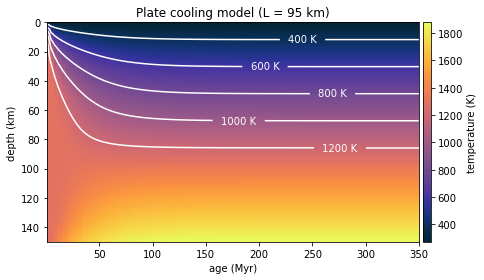

In [20]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
tmp = ax.pcolormesh(
    age, depth, temperatures,
    cmap=cmocean.cm.thermal,
)
plt.colorbar(tmp, ax=ax, aspect=30, pad=0.01, label="temperature (K)")
cs = ax.contour(age, depth, temperatures, levels=np.arange(400, 1201, 200), colors="w")
ax.clabel(cs, inline=1, fontsize=10, fmt="%.0f K")
ax.set_title("Plate cooling model (L = 95 km)")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("depth (km)")
ax.set_ylim(depth.max(), depth.min())
plt.tight_layout()
plt.savefig("plate-temperature.png", dpi=200)
plt.show()

## Heat flow from the plate model

We can predict the heat flow at the surface form the plate model by taking the derivative with respect to depth and evaluating it at the surface.

In [21]:
def plate_heat(age, thickness, surface_temperature, asthenosphere_temperature, diffusivity, conductivity, degree=100):
    """
    Heat flow from the plate cooling model.
    
    Parameters
    ----------
    age
        Lithosphere age in million years.
    thickness
        The thickness of the plate in km
    surface_temperature
        Temperature of the surface boundary condition in K. 
    asthenosphere_temperature
        Temperature of the asthenosphere used as an initial condition in K.
    diffusivity
        Thermal diffusivity in mm²/s.
    conductivity
        Thermal conductivity in W/mK.
    degree
        The maximum number of elements of the infinite series.
    
    Returns
    -------
    heat_flow
        Model heat flow at the surface in mW/m².
    """
    # 31557600000000 converts from Myr to seconds
    # 1e-12 converts from mm² to km²
    flow = 1
    for n in range(1, degree + 1):
        flow += (
            2 * np.exp(-diffusivity * 1e-12 * n**2 * np.pi**2 * age * 31557600000000 / thickness**2)
        )    
    # 1000 converts from W to mW (miliWatts)
    # 1e3 converts from km to m
    flow *= 1000 * conductivity * (asthenosphere_temperature - surface_temperature) / (thickness * 1e3)
    return flow

Now we can predict some values and compare them to the observations. Parameters were taken from Geodynamics section 4.16.

In [22]:
ages = np.linspace(1, 210, 100)
flow_halfspace = halfspace_heat(ages, surface_temperature=273, asthenosphere_temperature=1573, diffusivity=1, conductivity=3.3)

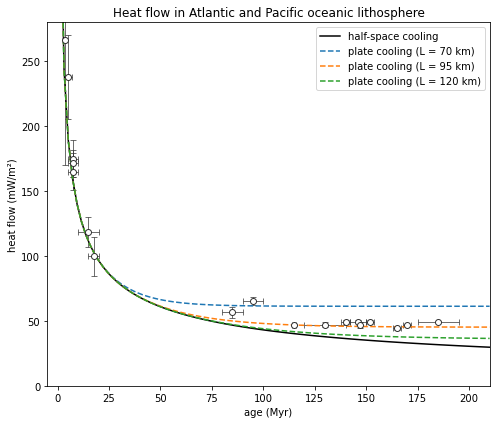

In [23]:
plt.figure(figsize=(7, 6))
ax = plt.axes()
ax.errorbar(
    heat_flow.age_mean, heat_flow.heat_flow,
    xerr=heat_flow.age_error,
    yerr=heat_flow.error,
    fmt="o", 
    markerfacecolor="w",
    color="#333333",
    capsize=3,
    capthick=0.7,
    elinewidth=0.7,
)
ax.plot(ages, flow_halfspace, "-k", label="half-space cooling")
for thickness in [70, 95, 120]:
    flow_plate = plate_heat(
        ages, 
        thickness=thickness, 
        surface_temperature=273, 
        asthenosphere_temperature=1573, 
        diffusivity=1, 
        conductivity=3.3
    )
    ax.plot(ages, flow_plate, "--", label=f"plate cooling (L = {thickness} km)")
ax.legend()
ax.set_title("Heat flow in Atlantic and Pacific oceanic lithosphere")
ax.set_xlabel("age (Myr)")
ax.set_ylabel("heat flow (mW/m²)")
ax.set_ylim(0, 280)
ax.set_xlim(-5, 210)
plt.tight_layout()
plt.savefig("lithospheric-heat-flow-plate.png", dpi=200)
plt.show()